### Описание задачи

Разработать сервис для предсказания стоимости домов на основе истории предложений.

Импортируем необходимые библиотеки:

In [5]:
import re
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn import metrics #метрики
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import preprocessing #предобработка
import sklearn.preprocessing as pp # импорт для работы с кодировщиком
from sklearn.model_selection import train_test_split #сплитование выборки
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import optuna
from datetime import date
from sklearn import model_selection #методы разделения и валидации

import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')

%matplotlib inline

Прочитаем исходные данные:

In [6]:
data = pd.read_csv('data/data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


**Признаки:**

* status - статус продажи
* private pool и PrivatePool - наличие частного бассейна,
* propertyType - тип недвижимости, поместья, свойства,
* street - адрес дома
* baths - количество ванных комнат
* homeFacts - сведения о строении дома, содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры
* fireplace - сведения о наличии камина(ов) в доме
* city - город
* schools - сведения о школах в районе
* sqft - площадь дома в футах
* zipcode - почтовый индекс
* beds - количество спален в доме
* state - государство/штаты
* stories - этажность недвижимости
* mls-id и MlsId - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
* target - целевой признак, который необходимо спрогнозировать - цена недвижимости

Выводим информацию о признаках:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Все признаки имеют формат object, необходимо преобразование.

Проверяем наличие пропусков:


In [8]:
data.isnull().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

Выводим описательные статистики признаков:

In [9]:
data.describe(include='object')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Проверяем данные на наличие дубликатов и удаляем их:

In [10]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 50
Размер таблицы после удаления дубликатов: (377135, 18)


Удаляем строки с попущенными значениями в целевом столбце:

In [11]:
data.dropna(axis = 'index', subset = ['target'], inplace = True)
print('Количество строк: {}'.format(data.shape[0]))

Количество строк: 374655


### Подготовка данных (предобработка)

Преобразуем целевой столбец - убираем все не цифровые знаки и приводим к числовому типу

In [12]:
def get_target(arg):
    arg = arg.replace(' ', '').replace(',' , '').replace('+', '').replace('$', '').replace('/', '')
    arg = re.sub(r'[A-Za-z]', '', arg)
    arg_list = arg.split('-')
    target = arg_list[0]
    return target
data['target'] = data['target'].apply(get_target)
data['target'] = data['target'].astype(float)

Преобразуем столбец с данными о статусе объекта недвижимости

In [13]:
def get_status(arg):
    # Создаём списки топ слов, остальные пометим как other 
    for_sale = ['for']
    active = ['active', 'a', 'active/contingent']
    fore_closure = ['foreclosure', 'auction', 'foreclosed', 'pre-foreclosure']
    pending = ['p', 'pending']
    contract = ['under', 'c']
    new = ['new', 'n']
    back_change = ['back','change']
    rent = ['rent']
    coming_soon = ['coming']
    # Приведем все символы к нижнему регистру
    # Разобьём на списки слов 
    splitted_st = arg.lower().split(' ')
    for i in splitted_st:
        if i in active:
            return 'active'
        elif i in for_sale:
            return 'for sale'
        elif i in fore_closure:
            return 'foreclosure'
        elif i in pending:
            return 'pending'
        elif i in new:
            return 'new'
        elif i in back_change:
            return 'back changes'
        elif i in rent:
            return 'rent'
        elif i in contract: 
            return 'contract'
        elif i in coming_soon: 
            return 'coming soon'
        else:
            return 'other'
#преобразовываем в строки и применяем функцию 
data['status'] = data['status'].astype(str).apply(get_status)

Преобразуем столбец с данными о типах жилища:

In [14]:
def get_type(arg):
    #Возьмем 5 самых часто встречаемых типов, остальные пометим как Other
    family_type_list = ['single-family home', 'Single Family', 'Single Family Home', 
                        'Detached', 'Tiny Home', 'Single Detached', 'SingleFamilyResidence', 'Single Detached, Traditional']
    condo_type_list = ['Condo', 'condo', 'coop', 'Condo/Townhome', 'Cooperative', 'Condo/Townhome/Row Home/Co-Op']
    land_list = ['lot/land', 'land']
    multi_fam_list = ['multi-family', 'Multi Family', 'Multi-Family Home', 'Multiple Occupancy']
    townhouse_list = ['townhouse', 'Townhouse', 'Townhome']
    if arg is np.nan or arg is '':
        return np.nan
    else:
        if arg in family_type_list:
            arg = 'Single Family'
        elif arg in condo_type_list:
            arg = 'Condo'
        elif arg in land_list:
            arg = 'Land'
        elif arg in multi_fam_list:
            arg = 'Multi Family'
        elif arg in townhouse_list:
            arg = 'Townhouse'
        else:
            arg = 'Other'
    return arg

data['propertyType'] = data['propertyType'].apply(get_type)
data['propertyType'] = data['propertyType'].fillna('Other')

Получаем информацию об объекте недвижимости из столбца 'homeFacts'

In [15]:
def get_lotsize_measure(home_facts_str):
    if re.search(r"acre['s]*", home_facts_str):
        return 'acre'
    return None

def process_home_facts(home_facts):
    #Переводим строку в нижний регистр
    home_facts = home_facts.lower()
    # Удаляем запятые между цифрами
    home_facts = re.sub(r'(\d),(\d)', r'\1\2', home_facts)
    # Удаляем '$'
    home_facts = home_facts.replace('$', '')
    # Удаляем ' sqft', ' sq. ft.' и ' acres'
    home_facts = home_facts.replace(' sqft', '')
    home_facts = home_facts.replace('/sqft', '')
    home_facts = home_facts.replace(' sq. ft.', '')
    # Удаляем ' lot', ' acre' и 'contact manager'
    home_facts = home_facts.replace(' lot', '')
    home_facts = home_facts.replace(' acres', '')
    home_facts = home_facts.replace(' acre', '')
    home_facts = home_facts.replace('contact manager', '')
    # Удаляем ' /', '—', '-' и 'no info' 
    home_facts = home_facts.replace('—', '')
    home_facts = home_facts.replace('-', '')
    home_facts = home_facts.replace(' /', '')
    home_facts = home_facts.replace('no info', '')
    return home_facts
data['homeFacts'] = data['homeFacts'].apply(lambda x: str(x).lower())
data['lotsize_measure'] = data['homeFacts'].apply(get_lotsize_measure)
# Проходим циклом по все строкам столбца 'homeFacts'
for i, row in data.iterrows():
    home_facts = row['homeFacts']
    home_facts = process_home_facts(home_facts)
    data.at[i, 'homeFacts'] = home_facts
# Задаем регулярное выражение для поиска пары ключ-значение
pattern = r"{'factvalue': '(.*?)', 'factlabel': '(.*?)'}"
# Проходим циклом по всем строкам столбца 'homeFacts'
for i, row in data.iterrows():
    home_facts_str = row['homeFacts']
    #Находим пару ключ-значение
    matches = re.finditer(pattern, home_facts_str)
    home_facts = {}
    for match in matches:
        factvalue = match.group(1)
        factlabel = match.group(2)
        home_facts[factlabel] = factvalue
    # Обновляем значение в столбце и переводим к типам:'year_built' и 'remodeled year' - int
    year_built = home_facts.get('year built', None)
    if year_built is None or year_built == 'no data' or year_built == '':
        data.at[i, 'year built'] = None
    else:
        data.at[i, 'year built'] = int(year_built)
    remodeled_year = home_facts.get('remodeled year', None)
    if remodeled_year is None or remodeled_year == 'no data' or remodeled_year == '':
        data.at[i, 'remodeled year'] = None
    else:
        data.at[i, 'remodeled year'] = int(remodeled_year)
    # 'heating', 'cooling', 'parking' - str
    data.at[i, 'heating'] = home_facts.get('heating', None)
    data.at[i, 'cooling'] = home_facts.get('cooling', None)
    data.at[i, 'parking'] = home_facts.get('parking', None)
    # 'lotsize', ' price' - float
    lot_size = home_facts.get('lotsize', None)
    if lot_size is None or lot_size == 'no data' or lot_size == '':
        data.at[i, 'lotsize'] = None
    else:
        data.at[i, 'lotsize'] = float(lot_size)
    price_sqft = home_facts.get('price', None)
    if price_sqft is None or price_sqft == 'no data' or price_sqft == '':
        data.at[i, 'price'] = None
    else:
        data.at[i, 'price'] = float(price_sqft)

Получаем информацио о школах в районе объекта недвижимости и добавляем столбцы со средним рейтингом и средним расстоянием до школы от объекта недвижимости:

In [16]:
data['schools'] = data['schools'].astype(str)
data['schools_rating'] = data['schools'].apply(lambda x: re.sub(r'data.*', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'/10', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x.replace('rating', ''))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-2])
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[1:])
# Создаем столбец 'school_count'
data['school_count'] = data['schools_rating'].apply(lambda x: (len(x.split(','))) if x != '' else 0)
data['school_count'] = data['school_count'].astype('int')
# Удаляем все символы, кроме цифр
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'\s+,', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-1])
# Создаем столбец 'schools_rating_list'
data['schools_rating_list'] = data['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])
# Создаем столбец 'schools_rating_ave'
data['schools_rating_ave'] = data['schools_rating_list'].apply(lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0)
data['schools_rating_ave'] = data['schools_rating_ave'].apply(np.round, decimals=2)
average = data['schools_rating_ave'].mean()
data['schools_rating_ave'] = data['schools_rating_ave'].apply(
    lambda x: average if x < 1 else x
)
def extract_text(text):
    pattern = r"Distance': \['(.+?)'\], 'Grades'"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

data['schools_distance'] = data['schools'].apply(extract_text)
data['schools_distance'] = data['schools_distance'].astype(str)
data['schools_distance'] = data['schools_distance'].apply(lambda x: re.sub(r'\smi', '', x))
data['schools_distance'] = data['schools_distance'].str.replace(r'[^\d.,\s]', '', regex=True)
data['schools_distance'] = data['schools_distance'].apply(lambda x: [float(num) for num in x.split(',')] if x else [])
data['schools_distance_ave'] = data['schools_distance'].apply(lambda x: round(sum(x)/len(x), 2) if x else 0)

Удаляем столбцы 'homeFact' и 'schools', вспомогательные столбцы для рассчета среднего рейтинга школы и среднего расстояния до школы. 

In [17]:
data = data.drop(['homeFacts',
                  'schools',
                  'schools_rating_list',
                  'schools_rating',
                  'schools_distance'
                  ],
                 axis=1)

Признак 'Год постройки' не очень информативен. Создадим новый признак - 'Возраст здания'& Вычисляем возраст здания на текцщий год

In [18]:
#Получаем текущую дату.
today = date.today()
#Получаем текущий год
this_year = today.year
#Вычисляем возраст здания
data['age_building'] = this_year - data['year built']
#Избавляемся от некорректных значений - возраст здания должен быть больше или равен 0
data = data[data['age_building'] >= 0]

Преобразуем столбец с данными о площади объекта недвижимости.

In [19]:
def get_sqft(arg):
        if isinstance(arg, float):
            return arg
        if arg is np.nan or arg in ['', 'no data', 'none'] :
            return np.nan
        if isinstance(arg, str):
            sqft = re.sub(r'\D', '', arg)
            if sqft != '':
                return sqft
            else:
                return np.nan
data['sqft'] = data['sqft'].apply(get_sqft)
data['sqft'] = data['sqft'].astype(float)

Столбцы 'PrivatePool' и 'private pool' содержат информацию о наличии частного бассейна, но информация в них не совпадает. Преобразуем данные в обоих столбцах к виду 1 - бассейн есть, 0 - бассейна нет и объединяем оба столбца в один столбец 'Pool'

In [20]:
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['private pool'] = data['private pool'].apply(lambda x: 1 if x == 'Yes' else 0)
data['Pool'] = data.apply(lambda x: (max(x['PrivatePool'], x['private pool'])), axis = 1)

Удаляем столбцы 'PrivatePool' и 'private pool' 

In [21]:
data = data.drop(['private pool','PrivatePool'], axis = 1)

Преобразуем столбецы 'fireplace', 'cooling', 'heating' и 'parking': 1 - если есть данные в столбце, 0 - если данных нет 

In [22]:
no_data_list = ['', 'no data', 'none', 'Not Applicable', 'No', ' ']
data['fireplace'] = data['fireplace'].apply(lambda x: 0 if x is np.nan or x in no_data_list  else 1)
data['cooling'] = data['cooling'].apply(lambda x: 0 if x is np.nan or x in no_data_list else 1)
data['heating'] = data['heating'].apply(lambda x: 0 if x is np.nan or x in no_data_list  else 1)
data['parking'] = data['parking'].apply(lambda x: 0 if x is np.nan or x in no_data_list  else 1)

Преобразуем столбец с данными о количестве ванных комнат

In [23]:
def get_bath(arg):
    if isinstance(arg, float):
        return arg
    if arg is np.nan or arg is '' or arg is '—' or arg is 'no data' or arg is 'none':
        return np.nan
    if isinstance(arg, str):
        arg = arg.replace(' ', '').replace(',' , '.').replace('+', '').replace('~', '').replace(':', '')
        bath = re.sub(r'[A-Za-z]', '', arg)
        bath = bath.replace('..', '')
        bath_list = bath.split('-')
        bath = bath_list[0]
        bath = bath.replace('—', '')
        bath_list_1 = bath.split('/')
        bath = bath_list_1[0]
        if bath != '':
            return bath
        else:
            return np.nan
data['baths'] = data['baths'].apply(get_bath)
data['baths'] = data['baths'].astype(float)

Преобразуем столбец с данными о кличестве спален

In [24]:
def get_beds(arg):
    if isinstance(arg, float):
        return arg
    if arg is np.nan or arg is '' or arg is '—' or arg is 'no data' or arg is 'none':
        return np.nan
    if isinstance(arg, str):
        if (re.search(r'acre|acres|sqft|\$', arg)) is None:
            beds = re.sub(r'[A-Za-z:+~#]', '', arg)
            beds = beds.replace(' ', '')
            beds_list = beds.split(',')
            beds = beds_list[0]
            beds_list_1 = beds.split('-')
            beds = beds_list_1[0]
            if beds != '':
                return beds
            else:
                return np.nan
        else:
            return np.nan            
data['beds'] = data['beds'].apply(get_beds)
data['beds'] = data['beds'].astype(float)

Проверяем столбцы на наличие одинаковых значений

In [25]:
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

mls-id: 99.87% уникальных значений
lotsize_measure: 100.0% одинаковых значений


Удаляем столбец 'lotsize_measure' - в нем все значения одинаковые. Столбцы 'mls-id' и 'MlsID' являются уникальными для каждого объекта недвижимости, не имеют никакого значения для предсказания стоимости объекта недвижимости, поэтому их также удаляем.

In [26]:
data = data.drop(['lotsize_measure',
                'mls-id',
                'MlsId'
                ]
                , axis=1)
print(f'Результирующее число признаков: {data.shape[1]}')

Результирующее число признаков: 24


Удаляем ненужные столбцы:

In [27]:
data = data.drop(['zipcode', 
                  'street',
                  'city',
                  'year built'
                  ],
                 axis=1)

Заполняем пропуски в данных медианными значениями:

In [28]:
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'baths': data['baths'].median(),
    'sqft': data['sqft'].median(),
    'beds': data['beds'].median(),
    'age_building': data['age_building'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
data = data.fillna(values)

Удаляем столбцы, в которых более 30% пропусков и строки, в которых есть хотя бы один пропуск.

In [29]:
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
data = data.dropna(thresh=thresh, axis=1)
data = data.dropna(how='any')
print('Размер таблицы: {}'.format(data.shape))

Размер таблицы: (228389, 18)


### Исследование данных

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений.

Построим график распределения целевой переменной и признака, отвечающего за площадь объекта в обычном и логарифмическом масштабе.

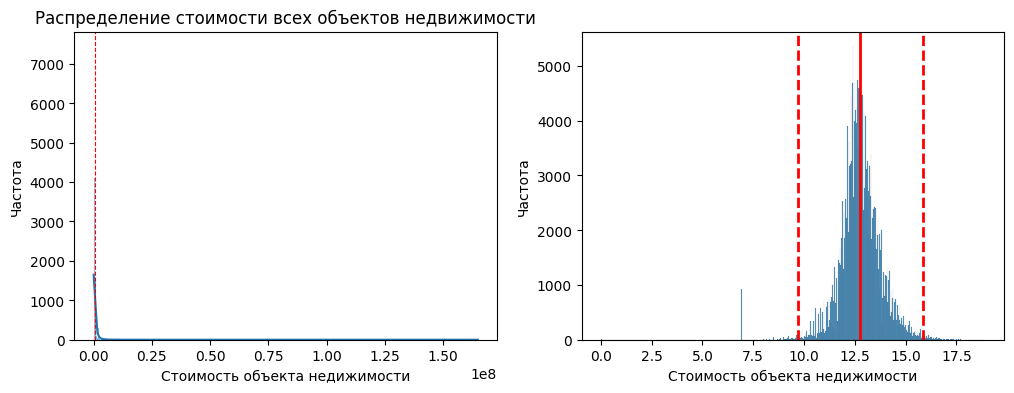

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data['target'], kde=True, ax=axes[0])
axes[0].set(xlabel='Стоимость объекта недижимости', ylabel='Частота')
axes[0].set_title('Распределение стоимости всех объектов недвижимости')
axes[0].axvline(data['target'].mean(), color='red', linestyle='--', linewidth=0.8)
log_target = np.log(data['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].set(xlabel='Стоимость объекта недижимости', ylabel='Частота')
axes[1].axvline(log_target.mean(), color='red', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='red', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='red', ls='--', lw=2);

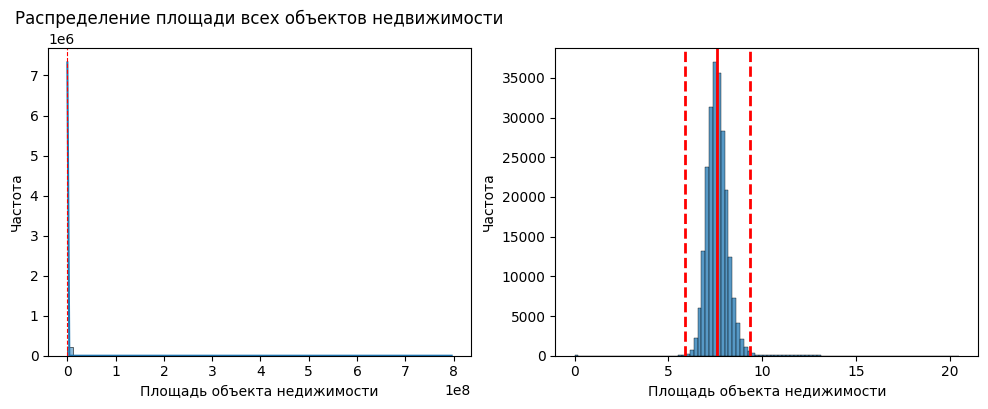

In [31]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
sns.histplot(data['sqft'], bins=70, kde=True, ax=axes[0])
axes[0].set(xlabel='Площадь объекта недижимости', ylabel='Частота')
axes[0].set_title('Распределение площади всех объектов недвижимости')
axes[0].axvline(data['sqft'].mean(), color='red', linestyle='--', linewidth=0.8)
log_sqft = np.log(data['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft, bins=100, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].set(xlabel='Площадь объекта недижимости', ylabel='Частота')
axes[1].axvline(log_sqft.mean(), color='red', lw=2)
axes[1].axvline(log_sqft.mean()+ 3 *log_sqft.std(),
                color='red', ls='--', lw=2)
axes[1].axvline(log_sqft.mean()- 3 *log_sqft.std(),
                color='red', ls='--', lw=2);

Из графиков можно сделать вывод, что целевой признак и признак, отвечающий за площадь обекта не распределены нормально. Подтвердим визуальный вывод, проведя тест Шапиро-Уилка

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [32]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      
target = data['target']
sqft = data['sqft']
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))
# проводим тест Шапиро-Уилка

print('Целевой признак:')
result_target = stats.shapiro(target)
decision_normality(result_target[1])

print("Признак 'sqft':")
result_sqft = stats.shapiro(sqft)
decision_normality(result_sqft[1])

Уровень значимости alpha = 0.05
Целевой признак:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак 'sqft':
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Проверим гипотезу о том, что стоимость недвижимости с камином больше, чем стоимость недвижимости без него.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость дома с камином ($μ_1$) статистически меньше либо равен стоимости дома без камина ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость дома с камином ($μ_1$) статистически больше, чем стоимость дома без камина ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [33]:
# стоимость
target_fireplace = data.loc[data['fireplace']==1, 'target']
target_nofirepace = data.loc[data['fireplace']==0, 'target']

target_fireplace
# проводим тест Шапиро-Уилка
print('С камином:')
result = stats.shapiro(target_fireplace)
decision_normality(result[1])

print('Без камина:')
result = stats.shapiro(target_nofirepace)
decision_normality(result[1])

С камином:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Без камина:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Выбираем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [34]:
# проводим тест
_, p = stats.mannwhitneyu(target_fireplace, target_nofirepace, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Стоимость дома с камином больше, чем дома без камина

Проверим гипотезу о том, что стоимость недвижимости с бассейном, чем стоимость недвижимости без него.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость дома с бассейном ($μ_1$) статистически меньше либо равен стоимости дома без бассейна ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость дома с бассейном ($μ_1$) статистически больше, чем стоимость дома без бассейна ($μ_2$).

$$ H_1 : μ_1 > μ_2$$


С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [35]:
# стоимость
target_pool = data.loc[data['Pool']==1, 'target']
target_nopool = data.loc[data['Pool']==0, 'target']

# проводим тест Шапиро-Уилка
print('С бассейном:')
result = stats.shapiro(target_pool)
decision_normality(result[1])

print('Без бассейна:')
result = stats.shapiro(target_nopool)
decision_normality(result[1])

С бассейном:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Без бассейна:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [36]:
# проводим тест
_, p = stats.mannwhitneyu(target_pool, target_nopool, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Стоимость дома с бассейном больше, чем дома без бассейна

Очистим данные от выбросов с помощью метода 3-х сигм:

In [37]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    data = data[(x > lower_bound) & (x < upper_bound)]
    return data
data = outliers_z_score_mod(data, 'target', log_scale=True)
data = outliers_z_score_mod(data, 'sqft', log_scale=True)
print(f'Результирующее число записей: {data.shape[0]}')

Результирующее число записей: 224104


## Визуализации ##

### 1. Построим график распределения объектов по типам.

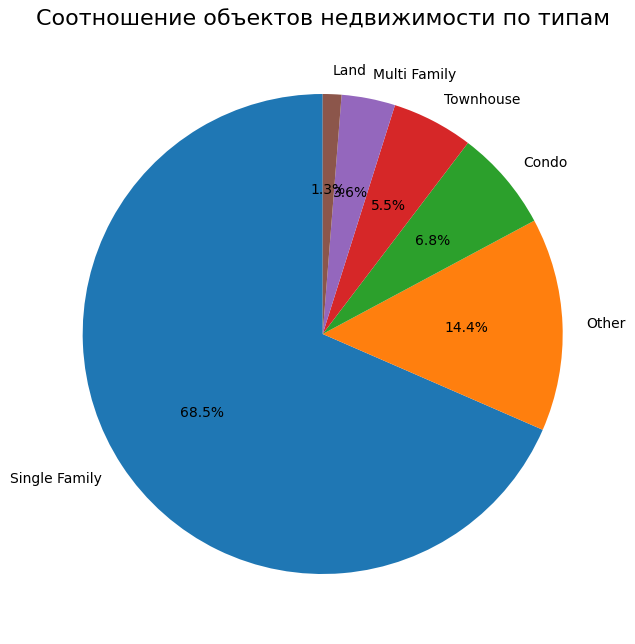

In [38]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))
data_1 = data['propertyType'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    data_1,
    labels=data_1.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение объектов недвижимости по типам', fontsize=16)
plt.show(pie)

Из графика можно сдлеать вывод, что основную долю недвижимости занимают дома/квартиры "Для одной семьи"

### 2. Построим график, показывающий наличие камина в доме/квартире по типам.

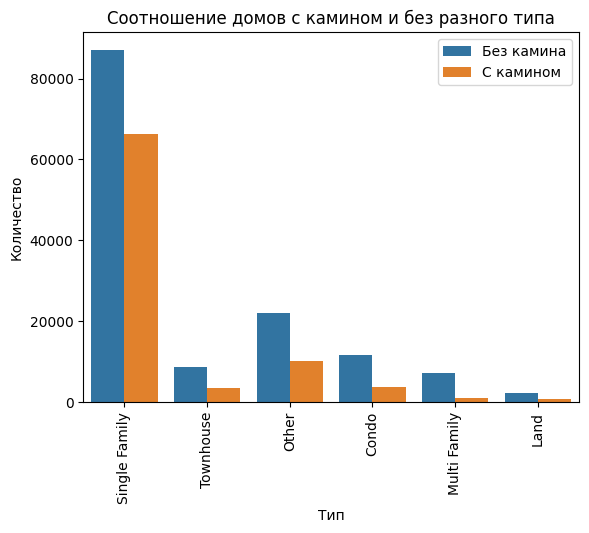

In [39]:
ax = sns.countplot(data=data, x=data['propertyType'], hue='fireplace')
ax.set(xlabel='Тип', ylabel='Количество')
ax.xaxis.set_tick_params(rotation=90)
plt.title('Соотношение домов с камином и без разного типа')
ax.legend(['Без камина', 'С камином'])
plt.show()

Из графика можно сделать вывод, что камины чаще всего встречаются в домах/квартирах "Для одной семьи"

### 3. Построим график, отображающий стоимость жтлья в зависимости от типа.

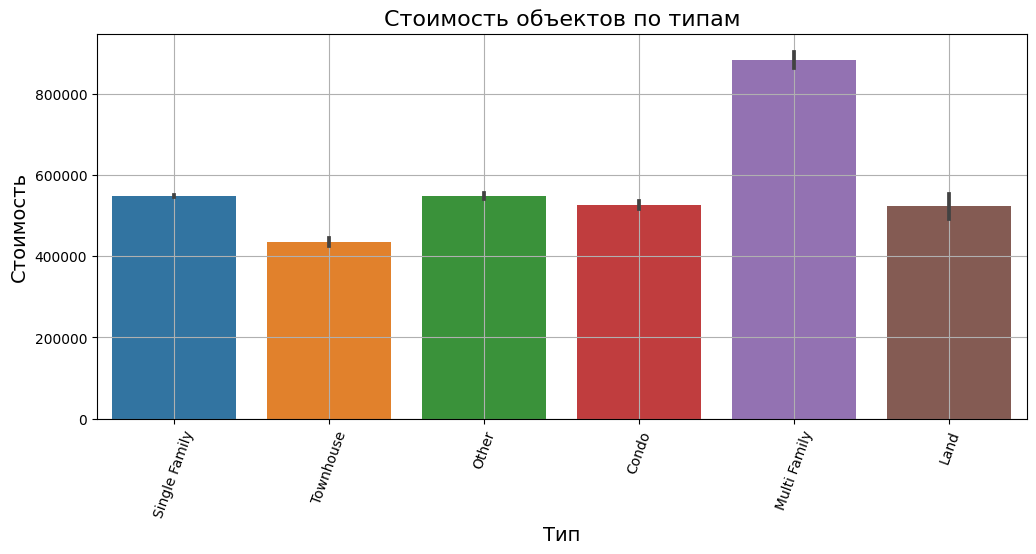

In [40]:
fig, axes = plt.subplots(figsize=(12, 5))
barplot1 = sns.barplot(
    data=data,
    x='propertyType',
    y='target',
    orient='v',
    ax = axes,
)
barplot1.tick_params(axis='x', rotation=70);
barplot1.set_title('Стоимость объектов по типам', fontsize=16);
barplot1.set_xlabel('Тип', fontsize=14);
barplot1.set_ylabel('Стоимость', fontsize=14);
barplot1.grid()


Наибольшую суммарную стоимость имеют объекты "многосемейные" или многоквартирые дома. Хоть доля домов "Для одной семьи" и выше, но стоимость таких объектов получается ниже.

### 4. Построим "диаграмму с усами", показывающую зависимость стоимости объекта недвижимости в зависимости от типа.

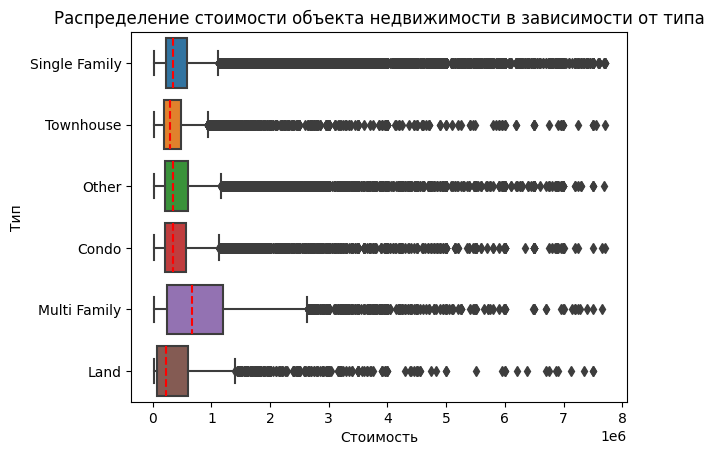

In [41]:
ax = sns.boxplot(data, x='target', y='propertyType', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость', ylabel='Тип')
plt.title('Распределение стоимости объекта недвижимости в зависимости от типа')
plt.show()

Медианная стоимость у всех объектов недвижимости находится почти на огдном уровне, но наблюдается довольно сильный разброс значений.

## ------------------ ##

Выведем таблицу, показывающую средний возраст зданий по типам.

In [42]:
data_age = data.groupby('propertyType')['age_building'].median().sort_values()
print('Средний возраст объекта недвижимости по типам:')
data_age

Средний возраст объекта недвижимости по типам:


propertyType
Townhouse        35.0
Condo            38.0
Single Family    39.0
Other            40.0
Land             72.0
Multi Family     94.0
Name: age_building, dtype: float64

Наиболее "старые" дома в нашем наборе данных - многоквартирные. 

Построим матрицу корреляции, а также ее тепловую карту. 

,index,target
4,target,1.000000
9,price,0.687813
2,sqft,0.610569
3,beds,0.323806
11,schools_rating_ave,0.258257
14,Pool,0.199003
1,fireplace,0.131763
7,parking,0.062548
0,baths,0.052717
12,schools_distance_ave,0.006989


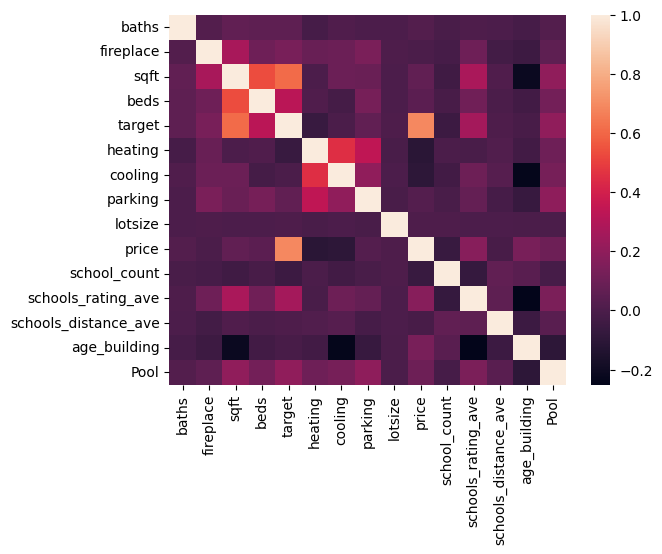

In [43]:
corr = data.corr()
sns.heatmap(corr)
new_corr = corr['target'].reset_index()
sort_corr = new_corr.sort_values('target', ascending=False)
sort_corr

Кодируем категориальные признаки OneHot кодированием

In [44]:
columns_to_change = ['propertyType', 'state', 'status']
encoder = pp.OneHotEncoder(drop='first') 
data_onehot = encoder.fit_transform(data[columns_to_change]).toarray()
# Получаем закодированные имена столбцов
column_names = encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data = pd.concat(
    [data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1)

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [45]:
X = data.drop(['target'], axis=1)
y = data['target']

Разделяем всю выборку на тренировочную и тестовую в соотношении 70/30.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

Предварительно нормализуем данные

In [47]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Моделирование + Оценка модели

Цель- построить модель, решающую поставленную задачу и оценить ее качество

Будем оценивать модель с помощью следующих метрик:

1. $R^2$ - коэффициент детерминации  
2. MAE - средняя абсолютная ошибка (целевая метрика)
3. MAPE - средняя абсолютная ошибка в процентах

In [48]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

**Модель линейной регрессии:**

Модель линейной регрессии имеет следующий вид:
$$\widehat{y_i}= w_0+\sum_{j=0}^m w_j x_{ij}$$
где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры линейной регрессии

Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 

В качестве функции потерь используем MSE - средний квадрат ошибки.

$$L(\omega) = MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - \widehat{y_i})^2} \Rightarrow min_\omega $$

**Аналитическое решение: метод наименьших квадратов (OLS):**

$$\omega=(X^TX)^{-1}X^Ty$$

In [49]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.796
Train MAE: 156724.006
Train MAPE: 56.376 %


Test R^2: 0.805
Test MAE: 157585.913
Test MAPE: 56.741 %


Попробуем улучшить значения метрик.

Так как целевой признак не распределен нормально - попробуем перевести целевой признак в нормальное распределение с помощью логарифмирования

In [50]:
#Создаем логарифмированный целевой признак
y_train_log = np.log(y_train)
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
## Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(lr.predict(X_train_scaled))
y_test_pred = np.exp(lr.predict(X_test_scaled))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: -332039713613668864.000
Train MAE: 1036426649450.343
Train MAPE: 15943901.555 %


Test R^2: -200050.355
Test MAE: 1930332.192
Test MAPE: 62.209 %


Используем дерево решений

In [51]:
# Инициализируем модель дерева решений с максимальной глубиной 5 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=5, #глубина
    criterion='squared_error', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
dt.fit(X_train_scaled, y_train_log)

#Делаем предсказание для каждой из выборок
## Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(dt.predict(X_train_scaled))
y_test_pred = np.exp(dt.predict(X_test_scaled)) 
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.860
Train MAE: 105908.090
Train MAPE: 17.526 %


Test R^2: 0.860
Test MAE: 106767.577
Test MAPE: 17.643 %


Попробуем применить модель Случайного леса:

In [52]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева 
rf = ensemble.RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)
# Обучаем модель
rf.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
## Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(rf.predict(X_train_scaled))
y_test_pred = np.exp(rf.predict(X_test_scaled))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.998
Train MAE: 9461.291
Train MAPE: 1.655 %


Test R^2: 0.997
Test MAE: 10271.746
Test MAPE: 1.759 %


Сделаем подбор оптимальных параметров с помощью RandomizeSearch

In [53]:
param_distributions = {'n_estimators': list(range(10, 50, 5)),
              'min_samples_leaf': list(range(1, 10, 1)),
              'max_depth': list(np.linspace(10, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train_log) 

#Делаем предсказание класса
y_train_pred = np.exp(random_search_forest.predict(X_train_scaled))
y_test_pred = np.exp(random_search_forest.predict(X_test_scaled))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 24.1 s, sys: 434 ms, total: 24.6 s
Wall time: 2min 52s
Train R^2: 1.000
Train MAE: 1533.682
Train MAPE: 0.239 %


Test R^2: 0.999
Test MAE: 3451.111
Test MAPE: 0.581 %
Наилучшие значения гиперпараметров: {'n_estimators': 30, 'min_samples_leaf': 1, 'max_depth': 30}


Постороим диаграмму значимости признаков

Text(0.5, 1.0, 'Bar plot feature importances')

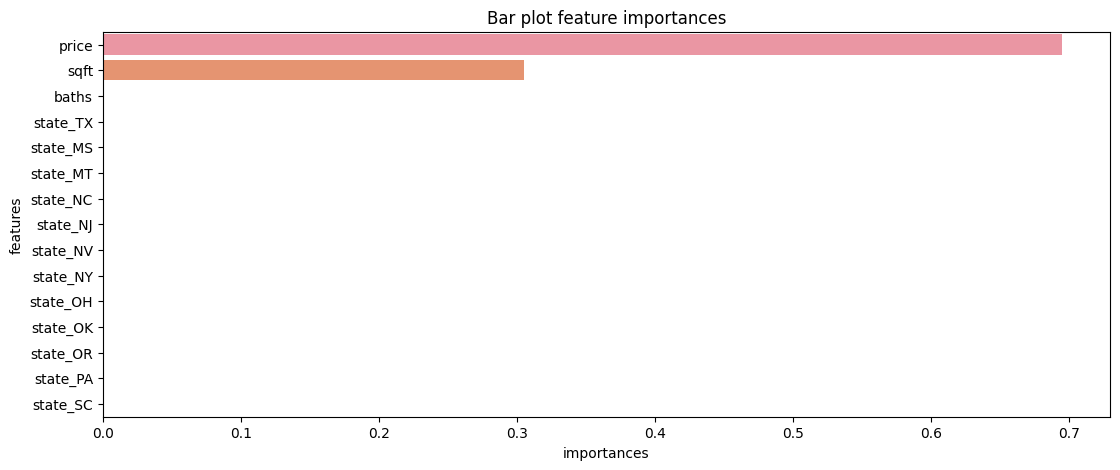

In [55]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
features = X.columns #признаки
feature_importances = dt.feature_importances_ #важность признаков
# Создаём DataFrame, содержащий информацию о важности признаков
importances_data = pd.DataFrame({'features': features, 'importances': feature_importances})
importances_data = importances_data.sort_values(by='importances', ascending=False)
# Строим столбчатую диаграмму
sns.barplot(data=importances_data[0:15], y='features', x='importances', ax=ax);
# Добавляем подпись к графику и поворот меток на оси абсцисс
ax.set_title('Bar plot feature importances')

Наибольшее влияние на результат оказывает признак 'price'. Это можно расценивать как утечку. Удалим данный признак.

In [56]:
X = data.drop(['price','target'], axis=1)
y = data['target']

Разделяем всю выборку на тренировочную и тестовую в соотношении 70/30.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

Нормализуем данные и подбираем парметры с помощью RandomizeSearch

In [58]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
param_distributions = {'n_estimators': list(range(10, 50, 5)),
              'min_samples_leaf': list(range(1, 10, 1)),
              'max_depth': list(np.linspace(10, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train_log) 

#Делаем предсказание класса
y_train_pred = np.exp(random_search_forest.predict(X_train_scaled))
y_test_pred = np.exp(random_search_forest.predict(X_test_scaled))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 20.9 s, sys: 329 ms, total: 21.2 s
Wall time: 3min 27s
Train R^2: 0.892
Train MAE: 84366.274
Train MAPE: 14.908 %


Test R^2: 0.712
Test MAE: 160108.138
Test MAPE: 31.042 %
Наилучшие значения гиперпараметров: {'n_estimators': 25, 'min_samples_leaf': 2, 'max_depth': 30}


Произведем отбор признаков с помощью KBest. Отберем 30 признаков.

In [59]:
feature_function = SelectKBest(k=30)
X_train = X_train.select_dtypes([np.number])
feature_function.fit(X_train, y_train)
columns_kbest = feature_function.get_feature_names_out()
print(columns_kbest)

['fireplace' 'sqft' 'beds' 'heating' 'cooling' 'parking' 'school_count'
 'schools_rating_ave' 'schools_distance_ave' 'age_building' 'Pool'
 'propertyType_Multi Family' 'state_CA' 'state_CO' 'state_DC' 'state_FL'
 'state_IA' 'state_MI' 'state_NC' 'state_NV' 'state_NY' 'state_OH'
 'state_OR' 'state_SC' 'state_TX' 'state_VA' 'state_WA'
 'status_foreclosure' 'status_new' 'status_pending']


Выделяем отобранные признаки из общего числа признаков

In [60]:
X_kbest = data[columns_kbest]
y_kbest = data['target']

Разбиваем выборку на тренировочную и тестовую в соотношении 70/30

In [61]:
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X_kbest, y_kbest, test_size=0.3, random_state=42)

Проводим нормализацию:

In [62]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_kbest)
X_train_kbest_scaled = scaler.transform(X_train_kbest)
X_test_kbest_scaled = scaler.transform(X_test_kbest)

Воспользуемся OPTUNA для подбора гиперпараметров

In [63]:
#Создаем логарифмированный целевой признак
y_train_kbest_log = np.log(y_train_kbest)
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_kbest_scaled, y_train_kbest_log)
  score = metrics.mean_absolute_percentage_error(y_train_kbest, np.exp(model.predict(X_train_kbest_scaled)))*100
  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_kbest_scaled, y_train_kbest_log)
y_train_kbest_pred = np.exp(model.predict(X_train_kbest_scaled))
y_test_kbest_pred = np.exp(model.predict(X_test_kbest_scaled))
print('MAPE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test_kbest, y_test_kbest_pred)*100))

[I 2024-07-06 18:44:49,015] A new study created in memory with name: RandomForestRegressor
[I 2024-07-06 18:45:03,274] Trial 0 finished with value: 35.231135962556706 and parameters: {'n_estimators': 40, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 0 with value: 35.231135962556706.
[I 2024-07-06 18:46:19,368] Trial 1 finished with value: 26.04549332976615 and parameters: {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 7}. Best is trial 1 with value: 26.04549332976615.
[I 2024-07-06 18:47:27,626] Trial 2 finished with value: 33.753611405378344 and parameters: {'n_estimators': 180, 'max_depth': 17, 'min_samples_leaf': 10}. Best is trial 1 with value: 26.04549332976615.
[I 2024-07-06 18:47:49,159] Trial 3 finished with value: 54.76560143402401 and parameters: {'n_estimators': 160, 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 26.04549332976615.
[I 2024-07-06 18:48:03,215] Trial 4 finished with value: 27.407199990790442 and parameters: {'n_estimat

Наилучшие значения гиперпараметров {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 7}
MAPE на обучающем наборе: 26.045
MAPE на тестовом наборе: 35.365


In [64]:
%%time
# продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

[I 2024-07-06 19:00:23,801] Trial 10 finished with value: 23.098466940740646 and parameters: {'n_estimators': 120, 'max_depth': 49, 'min_samples_leaf': 5}. Best is trial 10 with value: 23.098466940740646.
[I 2024-07-06 19:01:22,924] Trial 11 finished with value: 23.098466940740646 and parameters: {'n_estimators': 120, 'max_depth': 49, 'min_samples_leaf': 5}. Best is trial 10 with value: 23.098466940740646.
[I 2024-07-06 19:02:23,947] Trial 12 finished with value: 20.999315856281072 and parameters: {'n_estimators': 120, 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 12 with value: 20.999315856281072.
[I 2024-07-06 19:03:19,814] Trial 13 finished with value: 21.011856280167652 and parameters: {'n_estimators': 110, 'max_depth': 48, 'min_samples_leaf': 4}. Best is trial 12 with value: 20.999315856281072.
[I 2024-07-06 19:04:07,297] Trial 14 finished with value: 18.297193296680494 and parameters: {'n_estimators': 90, 'max_depth': 41, 'min_samples_leaf': 3}. Best is trial 14 with val

CPU times: user 7min 47s, sys: 944 ms, total: 7min 48s
Wall time: 7min 51s


In [65]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_kbest_scaled, y_train_kbest_log)
y_train_kbest_pred = np.exp(model.predict(X_train_kbest_scaled))
y_test_kbest_pred = np.exp(model.predict(X_test_kbest_scaled))
print('MAPE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test_kbest, y_test_kbest_pred)*100))

Наилучшие значения гиперпараметров {'n_estimators': 80, 'max_depth': 37, 'min_samples_leaf': 2}
MAPE на обучающем наборе: 14.837
MAPE на тестовом наборе: 33.747


Построим график истории оптимизации - он отображает количество испытаний на оси Х и метрику на оси Y. По графику видно, что метрика минимизируется.

In [66]:
optuna.visualization.plot_optimization_history(study, target_name="MAPE")

Постороим график важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию метрики.

In [67]:
optuna.visualization.plot_param_importances(study, target_name="MAPE")

По графику можно сделвать вывод, что стоит обратить большее внимание на настройку гиперпараметра max_depth

Исходя из метрик можно сделать вывод, что значения метрик лучше на полном наборе данных, без отбора признаков.

Проведем подбор гиперпараметров с помощью OPTUNA для полного набора признаков.

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков без учета признака 'price') и столбец правильных ответов y

In [68]:
X = data.drop(['price','target'], axis=1)
y = data['target']

Делим выборку на обучающую и тестовую в соотношении 70/30

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

Нормализуем данные

In [70]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Подбираем гиперпараметры с помощью OPTUNA

In [71]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = metrics.mean_absolute_percentage_error(y_train, np.exp(model.predict(X_train_scaled)))*100
  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))
print('MAPE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

[I 2024-07-06 19:10:43,647] A new study created in memory with name: RandomForestRegressor
[I 2024-07-06 19:11:32,498] Trial 0 finished with value: 40.88676778780706 and parameters: {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 40.88676778780706.
[I 2024-07-06 19:12:26,176] Trial 1 finished with value: 34.378378710298705 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 1 with value: 34.378378710298705.
[I 2024-07-06 19:14:18,141] Trial 2 finished with value: 18.302936475120166 and parameters: {'n_estimators': 140, 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 2 with value: 18.302936475120166.
[I 2024-07-06 19:14:40,287] Trial 3 finished with value: 24.518295121311464 and parameters: {'n_estimators': 30, 'max_depth': 31, 'min_samples_leaf': 8}. Best is trial 2 with value: 18.302936475120166.
[I 2024-07-06 19:15:14,473] Trial 4 finished with value: 26.803139933795826 and parameters: {'n_esti

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 44, 'min_samples_leaf': 4}
MAPE на обучающем наборе: 18.180
MAPE на тестовом наборе: 31.005


In [72]:
%%time
# продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

[I 2024-07-06 19:28:30,966] Trial 10 finished with value: 10.139371502387823 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 10 with value: 10.139371502387823.
[I 2024-07-06 19:31:45,442] Trial 11 finished with value: 10.139371502387823 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 10 with value: 10.139371502387823.
[I 2024-07-06 19:34:48,870] Trial 12 finished with value: 10.142883275193501 and parameters: {'n_estimators': 190, 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 10 with value: 10.139371502387823.
[I 2024-07-06 19:37:25,219] Trial 13 finished with value: 10.164197601823508 and parameters: {'n_estimators': 160, 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 10 with value: 10.139371502387823.
[I 2024-07-06 19:40:22,589] Trial 14 finished with value: 12.701078681428516 and parameters: {'n_estimators': 200, 'max_depth': 43, 'min_samples_leaf': 2}. Best is trial 10 with va

CPU times: user 23min 18s, sys: 5.35 s, total: 23min 23s
Wall time: 23min 33s


In [73]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f} %".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 50, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 10.139 %
MAPE на тестовом наборе: 29.861 %


Попробуем применить алгоритмы градиентного бустинга:

In [74]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(random_state=42, iterations=150)
#Обучаем модель
cb.fit(X_train_scaled, y_train_log)

#Делаем предсказание для тренировочной выборки
y_train_pred_cb = np.exp(cb.predict(X_train_scaled))
#Выводим значение метрики MAPE для тренировочной выборки
print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred_cb)*100))
#Делаем предсказание для тестовой выборки
y_test_pred_cb = np.exp(cb.predict(X_test_scaled))
#Выводим значение метрики MAPE для тестовой выборки
print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred_cb)*100))
print("Наилучшие значения гиперпарметров: {}".format(cb.get_params()))

Learning rate set to 0.425514
0:	learn: 0.7275846	total: 66.5ms	remaining: 9.9s
1:	learn: 0.6475839	total: 70.7ms	remaining: 5.23s
2:	learn: 0.5999210	total: 74.7ms	remaining: 3.66s
3:	learn: 0.5743220	total: 79.2ms	remaining: 2.89s
4:	learn: 0.5597413	total: 84ms	remaining: 2.44s
5:	learn: 0.5476117	total: 87.7ms	remaining: 2.1s
6:	learn: 0.5349623	total: 91.4ms	remaining: 1.87s
7:	learn: 0.5252046	total: 95.5ms	remaining: 1.7s
8:	learn: 0.5180656	total: 99.7ms	remaining: 1.56s
9:	learn: 0.5122900	total: 104ms	remaining: 1.45s
10:	learn: 0.5072658	total: 108ms	remaining: 1.36s
11:	learn: 0.5012444	total: 112ms	remaining: 1.29s
12:	learn: 0.4983094	total: 116ms	remaining: 1.22s
13:	learn: 0.4950379	total: 120ms	remaining: 1.17s
14:	learn: 0.4903520	total: 125ms	remaining: 1.12s
15:	learn: 0.4872226	total: 129ms	remaining: 1.08s
16:	learn: 0.4838605	total: 133ms	remaining: 1.04s
17:	learn: 0.4803458	total: 138ms	remaining: 1.01s
18:	learn: 0.4769936	total: 142ms	remaining: 977ms
19:	lea

In [75]:
from xgboost import XGBRegressor
#Создаем объект класса логистическая регрессия
xb = XGBRegressor(random_state=26)
#Обучаем модель, минимизируя logloss
xb.fit(X_train_scaled, y_train_log)

#Делаем предсказание для тренировочной выборки
y_train_pred_xb = np.exp(xb.predict(X_train_scaled))
#Выводим значение метрики f1-score для тренировочной выборки
print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred_xb)*100))
#Делаем предсказание для тестовой выборки
y_test_pred_xb = np.exp(xb.predict(X_test_scaled))
#Выводим значение метрики f1-score для тестовой выборки
print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred_xb)*100))

Train MAPE: 30.032 %
Test MAPE: 32.278 %


Так как значения метрик на тестовой выборке при использовании бустинга получаются чуть хуже значений метрики без использования бустинга остановимся на модели на основе Случайного леса с подбором оптимальных параметров с помощью OPTUNA

### ___________________ ###

Воспользуемся разбиением исходного набора данных на обучающую, валидационную и тестовую выборки.

Обучение будем производить на обучающем наборе данных, подбор параметров будем делать с помощью валидационной выборки, а оценивать результат подбора будем на тестовой выборке.

In [76]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 70/30
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

Нормализуем данные

In [77]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Логарифмируем целевую переменную:

In [78]:
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

In [79]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = metrics.mean_absolute_percentage_error(y_valid, np.exp(model.predict(X_valid_scaled)))*100
  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на тренировочном наборе: {:.3f} %".format(metrics.mean_absolute_percentage_error(y_train, np.exp(model.predict(X_train_scaled)))*100))
print("MAPE на валидационном наборе: {:.3f} %".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train_log)
y_valid_pred = np.exp(model.predict(X_valid_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

[I 2024-07-06 19:56:34,839] A new study created in memory with name: RandomForestRegressor
[I 2024-07-06 19:58:12,443] Trial 0 finished with value: 32.08397332677435 and parameters: {'n_estimators': 130, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 32.08397332677435.
[I 2024-07-06 19:59:42,794] Trial 1 finished with value: 32.25096678929188 and parameters: {'n_estimators': 120, 'max_depth': 46, 'min_samples_leaf': 6}. Best is trial 0 with value: 32.08397332677435.
[I 2024-07-06 20:01:49,018] Trial 2 finished with value: 33.43291041291104 and parameters: {'n_estimators': 180, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 0 with value: 32.08397332677435.
[I 2024-07-06 20:03:49,333] Trial 3 finished with value: 32.23769152212188 and parameters: {'n_estimators': 160, 'max_depth': 35, 'min_samples_leaf': 6}. Best is trial 0 with value: 32.08397332677435.
[I 2024-07-06 20:06:32,797] Trial 4 finished with value: 30.504474568688284 and parameters: {'n_estimator

Наилучшие значения гиперпараметров {'n_estimators': 190, 'max_depth': 41, 'min_samples_leaf': 2}
MAPE на тренировочном наборе: 10.139 %
MAPE на валидационном наборе: 30.504 %
MAPE на тестовом наборе: 29.757 %


In [80]:
%%time
# продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

[I 2024-07-06 20:21:52,954] Trial 10 finished with value: 30.451936469448288 and parameters: {'n_estimators': 70, 'max_depth': 39, 'min_samples_leaf': 1}. Best is trial 10 with value: 30.451936469448288.
[I 2024-07-06 20:23:25,079] Trial 11 finished with value: 30.54278076470862 and parameters: {'n_estimators': 60, 'max_depth': 39, 'min_samples_leaf': 1}. Best is trial 10 with value: 30.451936469448288.
[I 2024-07-06 20:25:27,971] Trial 12 finished with value: 30.41408841653997 and parameters: {'n_estimators': 80, 'max_depth': 39, 'min_samples_leaf': 1}. Best is trial 12 with value: 30.41408841653997.
[I 2024-07-06 20:27:14,029] Trial 13 finished with value: 31.182258843783337 and parameters: {'n_estimators': 80, 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 12 with value: 30.41408841653997.
[I 2024-07-06 20:27:44,945] Trial 14 finished with value: 31.123030515291482 and parameters: {'n_estimators': 20, 'max_depth': 42, 'min_samples_leaf': 1}. Best is trial 12 with value: 30.4

CPU times: user 15min 20s, sys: 2.82 s, total: 15min 23s
Wall time: 2h 52min 1s


In [81]:
# выводим результаты
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем точность для тестовой выборки
best_model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
best_model.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(best_model.predict(X_train_scaled))
y_valid_pred = np.exp(best_model.predict(X_valid_scaled))
y_test_pred = np.exp(best_model.predict(X_test_scaled))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100))
print('MAPE на валидационном  наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_valid, y_valid_pred)*100))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

Наилучшие значения гиперпараметров {'n_estimators': 80, 'max_depth': 39, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 10.466 %
MAPE на валидационном  наборе: 30.414 %
MAPE на тестовом наборе: 29.727 %


Записываем модель с оптимальными параметрами в файл

In [82]:
import pickle
# Производим сериализацию и записываем результат в файл формата pkl
with open('web/app/models/model_opt.pkl', 'wb') as output:
    pickle.dump(best_model, output)